# Add GSAA reference data to patches

```
#
# Copyright (c) Sinergise, 2019 -- 2021.
#
# This file belongs to subproject "field-delineation" of project NIVA (www.niva4cap.eu).
# All rights reserved.
#
# This source code is licensed under the MIT license found in the LICENSE
# file in the root directory of this source tree.
#
```

This script adds GSAA reference data to each EOPatch in vector and raster format.

The following features are added to eopatches:

 * original vector data
 * raster mask from pixelated vector data, 10m buffer
 * boundary mask (buffered raster minus raster pixelated)
 * normalised distance transform

## Requirement: Import shapefile to DB for faster processing

GSAA data for Lithuania is a rather large shapefile (~2.4G), which poses several issues:
  * multiprocessing the eopatches with EOExecutor explodes with too high RAM usage
  * loading the dataset takes a lot of time (even-though it happens only once, the dataset is practically copied for each process with multiprocessing, which takes time)
  * additionally, spatial index has to be build in order to make the process of extracting geometries for each eopatch fast
  
Instead, we set up a local postgre database (with postgis extension), imported shapefile into it, created spatial index, and created a simple EOTask that queries the db to get the geometries intersecting the eopatch bbox.

The following was done on amazon EC2 to install everything needed, set-up the db and import shapefile. If running this locally or on an another input geometry, make sure to adjust teh username, the CRSs and of course the paths to the files:

```bash
# install docker, add permissions to user ubuntu to run docker commands
sudo apt install docker.io
sudo service docker start
sudo usermod -a -G docker ubuntu

#so that user's permissions get picked up
sudo reboot 

#pull the docker image with everything ready (postgre, postgis, ...)
docker pull kartoza/postgis

#run the container
docker run --name "postgis" -p 25431:5432 -e POSTGRES_USER=niva -e POSTGRES_PASS=n1v4 -e POSTGRES_DBNAME=gisdb -e POSTGRES_MULTIPLE_EXTENSIONS=postgis,hstore -d -t kartoza/postgis

#some more things to install in order to import shp to db
sudo apt install postgis

#there are some issues with EPSG 3346 (Lithuanian crs), so in order to bypass them, I have converted the geometries to WGS84, using ogr2ogr, so I had to install gdal
sudo apt install gdal-bin

#convert to WGS84
ogr2ogr -t_srs epsg:4326 -lco ENCODING=UTF-8 -f 'Esri Shapefile' gsaa_4326.shp bucket/Declared_parcels_2019_03_S4C.shp

#create sql for import
shp2pgsql -s 4326 -I gsaa_4326.shp gsaa > gsaa.sql

#run the sql to import
psql -h localhost -U niva -p 25431 -d gisdb -f gsaa.sql
```

Now the data is in db `gisdb` in table `gsaa`. 



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sentinelhub import CRS, BBox

from eolearn.core import FeatureType, EOExecutor

In [4]:
from fd.gsaa_to_eopatch import GsaaToEopatchConfig, get_gsaa_to_eopatch_workflow

In [5]:
from fd.utils_plot import (draw_vector_timeless, 
                           draw_true_color, 
                           draw_bbox, 
                           draw_mask, 
                           get_extent
                          )

### Set paths and constants

In [6]:
INPUT_DATA_DIR = Path('../../input-data/')

### Set workflow configuration 

In [7]:
gsaa_to_eops_config = GsaaToEopatchConfig(
    bucket_name='',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='',
    database='gisdb',
    user='niva',
    password='n1v4',
    host='localhost',
    port='25431',
    crs=CRS.WGS84.pyproj_crs(),
    eopatches_folder='data/Castilla/2020-04/eopatches',
    vector_feature=(FeatureType.VECTOR_TIMELESS, 'GSAA_ORIGINAL'),
    extent_feature=(FeatureType.MASK_TIMELESS, 'EXTENT'),
    boundary_feature=(FeatureType.MASK_TIMELESS, 'BOUNDARY'),
    distance_feature=(FeatureType.DATA_TIMELESS, 'DISTANCE'),
    height=1100,
    width=1100
)

Load grid definition file from batch processes

In [8]:
grid_definition = gpd.read_file(INPUT_DATA_DIR/'cyl-grid-definition.gpkg')
grid_definition.head()

id       name                                           geometry
0  2302137  30TVM_2_5  POLYGON ((-3.96458 41.90790, -3.96594 41.99795...
1  2301391  30TUN_7_8  POLYGON ((-4.58294 42.53146, -4.58522 42.62148...
2  2301392  30TUN_7_9  POLYGON ((-4.58067 42.44143, -4.58294 42.53146...
3  2301398  30TUN_8_5  POLYGON ((-4.46755 42.80315, -4.46969 42.89318...
4  2301399  30TUN_8_6  POLYGON ((-4.46543 42.71313, -4.46755 42.80315...

Read eopatch list

In [9]:
eopatches_list = grid_definition.name.values
eopatches_list[100]

'30TVM_4_6'

Set up workflow

In [10]:
workflow = get_gsaa_to_eopatch_workflow(gsaa_to_eops_config)

Try on a patch

In [11]:
tasks = workflow.get_tasks()

In [11]:
result = workflow.execute({
    tasks['LoadTask']: {'eopatch_folder': '30TVM_4_6'},
    tasks['SaveTask']: {'eopatch_folder': '30TVM_4_6'}
    })

In [12]:
eop = list(result.values())[-1]

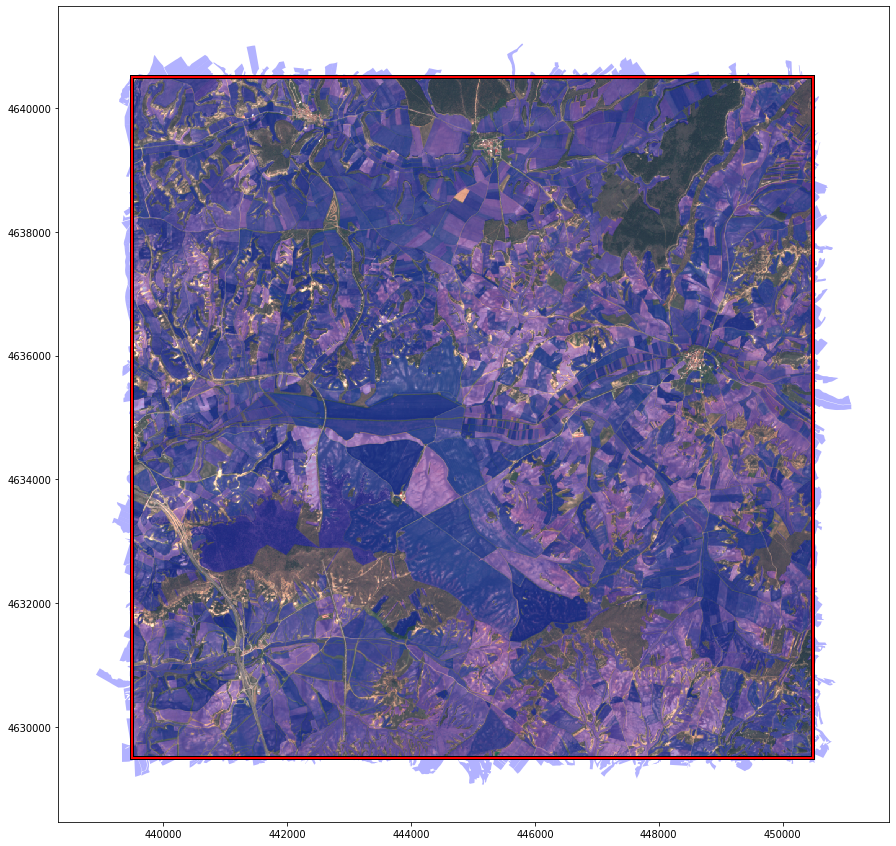

In [13]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_true_color(ax, eop, time_idx=4, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)
draw_bbox(ax, eop)
draw_vector_timeless(ax, eop, vector_name='GSAA_ORIGINAL', alpha=.3)

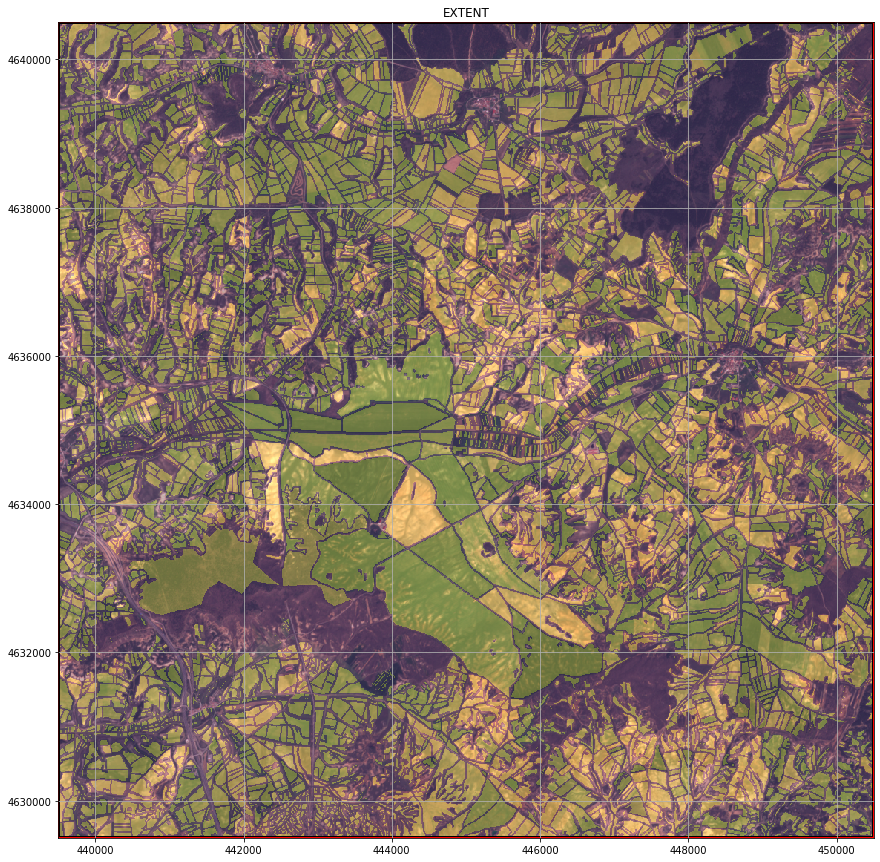

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_true_color(ax, eop, time_idx=4, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)
draw_bbox(ax, eop)
draw_mask(ax, eop, time_idx=None, feature_name='EXTENT', alpha=.3)

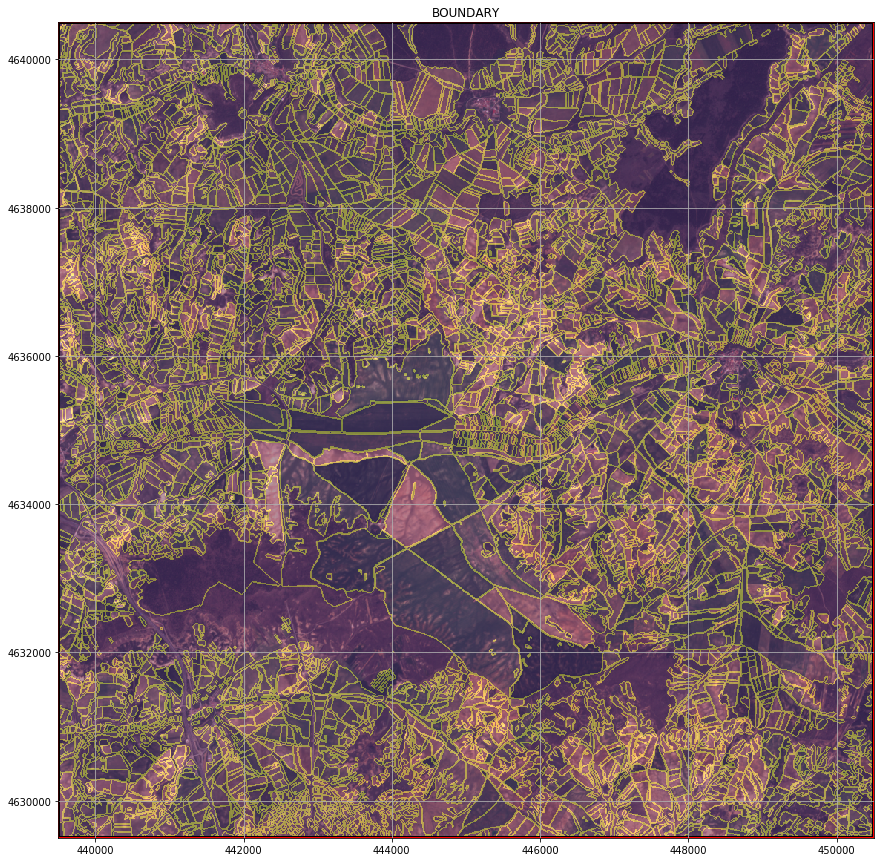

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_true_color(ax, eop, time_idx=4, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)
draw_bbox(ax, eop)
draw_mask(ax, eop, time_idx=None, feature_name='BOUNDARY', alpha=.4)

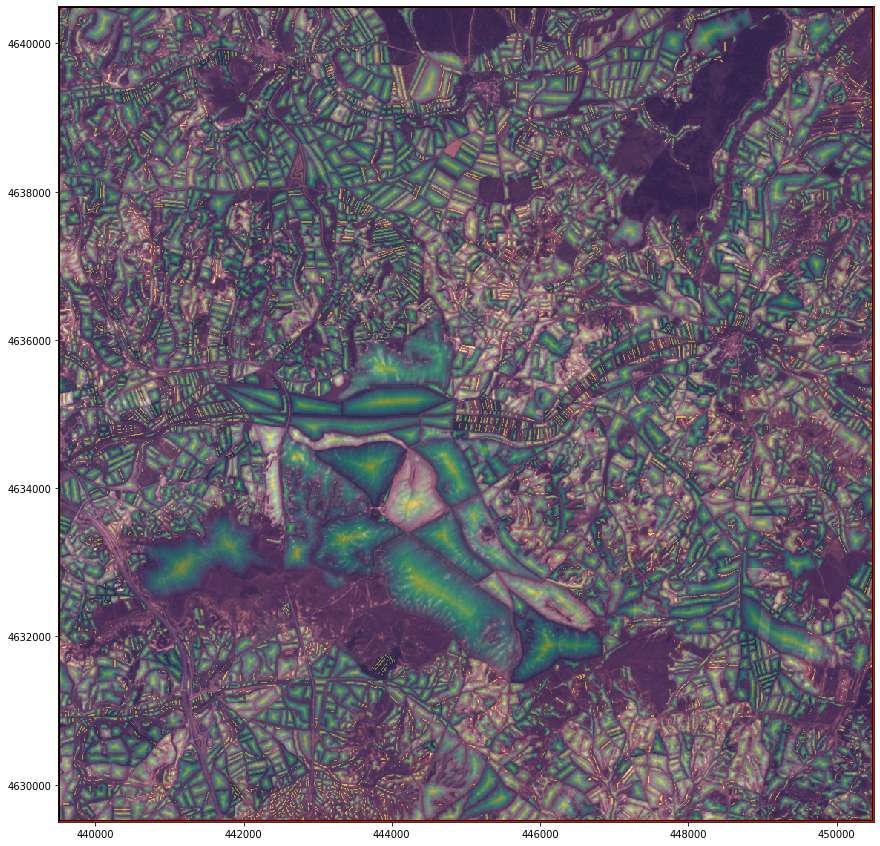

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_bbox(ax, eop)
draw_true_color(ax, eop, time_idx=4, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)
ax.imshow(eop.data_timeless['DISTANCE'].squeeze(), extent=get_extent(eop), alpha=.4)

Build list of inputs for execution

In [12]:
exec_args = []

for eopatch_name in tqdm(eopatches_list, total=len(eopatches_list)):

    single_exec_dict = {}

    single_exec_dict[tasks['LoadTask']] = dict(eopatch_folder=f'{eopatch_name}')

    single_exec_dict[tasks['SaveTask']] = dict(eopatch_folder=f'{eopatch_name}')

    exec_args.append(single_exec_dict)


Run on all eopatches in parallel

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [14]:
MAX_WORKERS = 24

executor = EOExecutor(workflow, exec_args, save_logs=True, logs_folder='.')

executor.run(workers=MAX_WORKERS)

In [15]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))

Using matplotlib backend: agg
Report was saved to location: ./eoexecution-report-2020_12_28-21_58_36/report.html


There will be failed EOPatches where ground-truth is not available, i.e. at the border of the contry. We can check this by plotting where the workflow failed.

In [16]:
failed = !grep failed -l /home/ubuntu/field-delineation/notebooks/data-download/eoexecution-report-2020_12_28-21_58_36/*log | awk '{system("grep eopatch_folder "$0)}' | awk -F "'" '{print $4}'

In [17]:
tiles = grid_definition[['name','geometry']].copy()

In [18]:
len(tiles)

1083

In [19]:
tiles['failed']=False
tiles.loc[tiles['name'].isin(failed), ['failed']]=True

In [20]:
%matplotlib inline

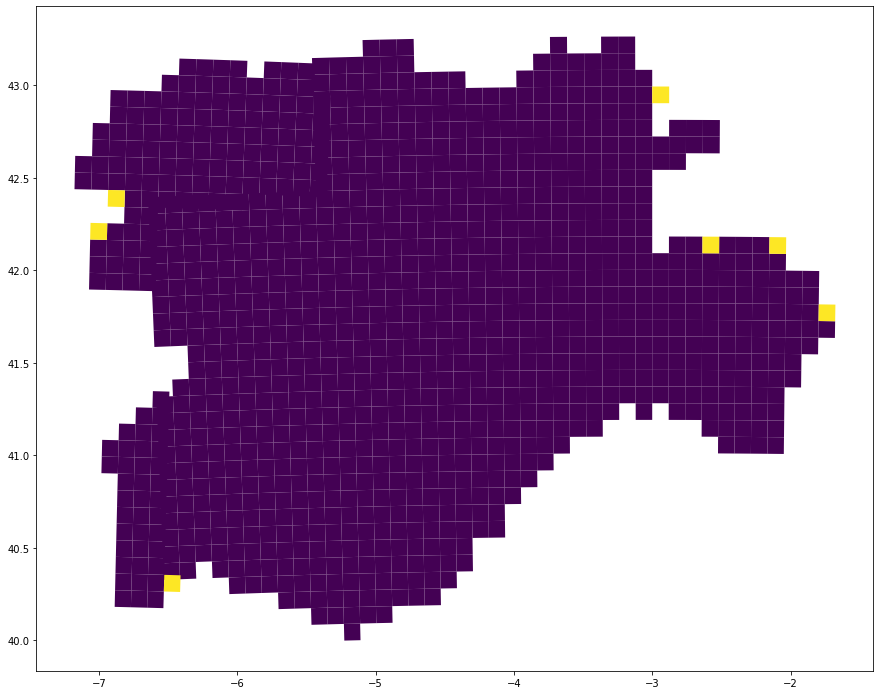

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))
tiles.plot(column='failed', ax=ax)